In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

(sec:theory_electionpolls)=
# Example: Simulating Election Poll Bias and Variance

In 2016, nearly every prediction for the outcome of the United States Presidential election was wrong. This was an historic level of prediction error that shocked the statistics and data science communities and would ultimately leave many questioning their sanity. In this chapter, we will examine why nearly every political poll was so confident and yet also so wrong. This story will both illustrate the power of simulation and also reveal the hubris of data and the challenge of bias.


The President of the United States is chosen by the Electoral College, and not solely by popular vote. Each state is allotted a certain number of votes to cast in the Electoral College, according to the size of their population. Typically, whomever wins the popular vote in a state receives all of the electoral college votes for that state. With the aid of polls conducted in advance of the election, pundits identify "battleground" states where the election is expected to be close and the electoral college votes might swing the election. 


In 2016, pollsters _correctly_ predicted the election outcome in 46 of the 50 states. Not bad! After all, for those 46 states, Trump received 231 and Clinton received 232 electoral college votes. Nearly a tie with Clinton having a very narrow lead. Unfortunately, the remaining 4 states, Florida, Michigan, Pennsylvania, and Wisconsin, were identified as battleground states and accounted for a total of 75 votes.  The margins of the popular vote in these four states were narrow. For example, in Pennsylvania, Trump received 48.18% and Clinton received 47.46% of the 6,165,478 votes cast. Such narrow margins can make it hard to predict the outcome given the sample sizes that the polls used. But there was an even greater challenge hidden in the sampling process itself.

Many experts have studied the 2016 election results to dissect and identify what went wrong. According to the American Association for Public Opinion Research[^AAPOR], one online, opt-in poll adjusted their polling results for the education of the respondents but used only three broad categories (high school or less, some college, and college graduate). They found that if they had separated out those with advanced degrees from those with college degrees, then they would have reduced Clinton’s margin by 0.5 percentage points. In other words, after the fact they were able to identify an education bias where highly educated voters tended to be more willing to participate in polls. This bias matters because these voters also tended to prefer Clinton over Trump.

Now that we know how people actually voted, we can carry out a simulation study that imitates election polling under different scenarios to help develop intuition for accuracy, bias, and variance[^grotenhuis]. We will simulate the polls for Pennsylvania under two scenarios: 

1. People surveyed didn't change their minds, didn't hide who they voted for, and were representative of those who voted on election day.
2. People with a higher education were more likely to respond, which led to a bias for Clinton.

Our ultimate goal is to understand the frequency that a poll incorrectly calls the election for Hillary Clinton when a sample is collected with absolutely no bias and also when there is a small amount of non-response bias. We begin by setting up the urn model for the first scenario.

[^AAPOR]: https://www.aapor.org/Education-Resources/Reports/An-Evaluation-of-2016-Election-Polls-in-the-U-S.aspx

[^grotenhuis]: https://blogs.lse.ac.uk/usappblog/2018/02/01/better-poll-sampling-would-have-cast-more-doubt-on-the-potential-for-hillary-clinton-to-win-the-2016-election/

## The Pennsylvania Urn Model

Our urn model for carrying out a poll of Pennsylvania voters is an after-the-fact situation where we use the outcome of the election. The urn has 6,165,478 marbles in it, one for each voter. Like with our tiny population, we write on each marble the candidate that they voted for, draw 1500 marbles from the urn (1500 is about the typical size of the polls), and tally up the votes for Trump, Clinton, and any other candidate. From the tally, we can calculate Trump's lead over Clinton. 

To set up our simulation, we figure out what the urn looks like. We need to know the number of votes cast for each of the candidates. Since we care only about Trump's lead over Clinton, we can lump together all votes for other candidates together. This way each marble has one of three possible votes: Trump, Clinton, and Other. We can't ignore the "Other" category, because it impacts the size of the lead.  

In [2]:
proportions = np.array([0.4818, 0.4746, 1 - (0.4818 + 0.4746)])               
n = 1_500 
N = 6_165_478
votes = np.trunc(N * proportions).astype(int)
votes

array([2970527, 2926135,  268814])

This version of the urn model has three types of marbles in it. It is a bit more complex than the hypergeometric, but still common enough to have a named distribution: the *multivariate hypergeometric*. In Python, the urn model with more than two types of marbles is implemented as the `scipy.stats.multivariate_hypergeom.rvs` method. The function returns the number of each type of marbel drawn from the urn. We call the function as follows. 

In [3]:
from scipy.stats import multivariate_hypergeom

multivariate_hypergeom.rvs(votes, n)

array([756, 691,  53])

As before, each time we call `multivariate_hypergeom.rvs` we get a different sample and counts.

In [4]:
multivariate_hypergeom.rvs(votes, n)

array([725, 714,  61])

We need to compute Trump's lead for each sample: $(n_T - n_C)/n$, where $n_T$ are the number of Trump votes in the sample and $n_C$ the number for Clinton. If the lead is positive, then the sample shows a win for Trump.

We know the actual lead was, 0.4818 - 0.4746 =  0.0072. To get a sense of the variation in the poll, 
we can simulate the chance process of drawing from the urn over and over and examine the values that we get in return. Below we simulate 100,000 polls of 1500 voters from the votes cast in Pennsylvania.  

In [5]:
def trump_advantage(votes, n):
    sample_votes = multivariate_hypergeom.rvs(votes, n)
    return (sample_votes[0] - sample_votes[1]) / n

In [6]:
simulations = [trump_advantage(votes, n) for _ in range(100000)] 

On average, the polling results show Trump with close to a 0.7% lead, as expected given the composition of the six-plus million votes cast.

In [7]:
np.mean(simulations)

0.007151273333333334

However, many times the lead in the sample was negative, meaning Clinton was the winner for that sample of voters.
The histogram below shows the sampling distribution of Trump's advantage in Pennsylvania for a sample of 1500 voters. 
The vertical dashed line at 0 shows that more often than not, Trump is called, but there are many times when the poll of 1,500 shows Clinton in the lead.

Text(0.5, 0, 'Trump Lead in the Sample')

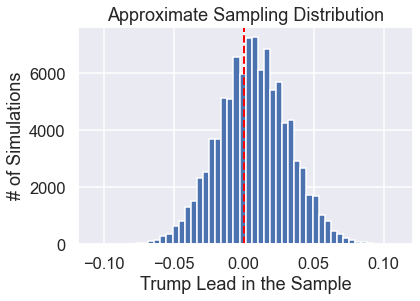

In [8]:
plt.hist(simulations, bins=50)
plt.axvline(0, color='red', linestyle='dashed', linewidth=2)
plt.title('Approximate Sampling Distribution')
plt.ylabel('# of Simulations')
plt.xlabel('Trump Lead in the Sample')

In the 100,0000 simulated polls, we find Trump a victor about 60% of the time: 

In [9]:
np.count_nonzero(np.array(simulations) > 0) / 100000

0.60586

In other words, a sample will correctly predict Trump's victory *even if the sample was collected with absoutely no bias* about 60% of the time. And, this unbiased sample will be wrong about 40% of the time. 

We have used the urn model to study the variation in a simple poll, and we  found how a poll's prediction might look if there was no bias in our selection process (the marbles are indistinguishable and every possible collection of 1500 marbles of the six-plus million marbles is equally likely). Next, we see what happens when a little bias enters into the mix.

## An Urn Model with Bias 

"In a perfect world, polls sample from the population of voters, who would state their political preference perfectly clearly and then vote accordingly."[^grotenhuisQ] That's the simulation study that we just performed. In reality, it is often difficult to control for every source of bias. 

We investigate here the effect of a small, education bias on the polling results. Specifically, we examine the impacts of 0.5 percent bias in favor of Clinton. This bias essentially means that we see a distorted picture of voter preferences in our poll. Instead of 47.46 percent votes for Clinton, we have 47.96, and we have 48.18 - 0.5 = 47.68 percent for Trump. 
We adjust the proportions of marbles in the urn to reflect this bias. 

[^grotenhuisQ]: https://blogs.lse.ac.uk/usappblog/2018/02/01/better-poll-sampling-would-have-cast-more-doubt-on-the-potential-for-hillary-clinton-to-win-the-2016-election/

In [10]:
proportions_bias = np.array([0.4818 - 0.005, 0.4747 + 0.005, 1 - (0.4818 + 0.4746) ])
proportions_bias

array([0.48, 0.48, 0.04])

In [11]:
votes_bias = np.trunc(N * proportions_bias).astype(int)
votes_bias

array([2939699, 2957579,  268814])

When we carry out the simulation study again, this time with the biased urn, we find a different result.

In [12]:
simulations_bias = [trump_advantage(votes_bias, n) for i in range(100000)] 

Text(0.5, 0, 'Trump Lead in the Sample')

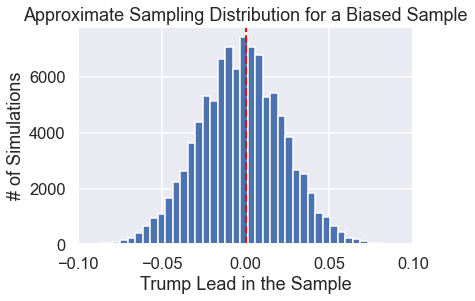

In [13]:
plt.hist(simulations_bias, bins=50)
plt.axvline(0, color='red', linestyle='dashed', linewidth=2)
plt.xlim([-0.1, 0.1])
plt.title('Approximate Sampling Distribution for a Biased Sample') 
plt.ylabel('# of Simulations')
plt.xlabel('Trump Lead in the Sample')

In [14]:
np.count_nonzero(np.array(simulations_bias) > 0) / 100000

0.44896

Now, Trump would have a positive lead in about 45% of the polls. Notice that the histograms from the two simulations are similar in shape. They are symmetric with reasonable length tails. That is, they appear to roughly follow the normal curve. The second histogram is shifted slightly to the left, which reflects the non-response bias we introduced. Would increasing the sample size have helped? This is the topic of the next section. 

##  Conducting Larger Polls

With our simulation study we can gain insight on the impact of a larger poll on the sample lead. For example, we can try a sample size of 12,000, eight times the size of the actual poll, and run 100,000 simulations for both scenarios: the unbiased and the biased.

In [15]:
simulations_big = [trump_advantage(votes, 12000) for i in range(100000)] 
simulations_bias_big = [trump_advantage(votes_bias, 12000) for i in range(100000)] 

In [16]:
scenario_no_bias = np.count_nonzero(np.array(simulations_big) > 0) / 100000
scenario_bias = np.count_nonzero(np.array(simulations_bias_big) > 0) / 100000
print(scenario_no_bias, scenario_bias)

0.78856 0.37078


The simulation shows that Trump's lead is detected in only about one-third of the simulated biased scenario. The spread of the histogram of these results is narrower than the spread when only 1,500 voters were polled. Unfortunately, it's narrowing in on the wrong value.  We haven't overcome the bias; we just have a more accurate picture of the biased situation. Big data has not come to the rescue. Additionally, larger polls have other problems. They are often harder to conduct because pollsters are working with limited resources and efforts that go into improving the data scope are being redirected to expanding the poll. 

Text(0.5, 0, 'Trump Lead in the Sample')

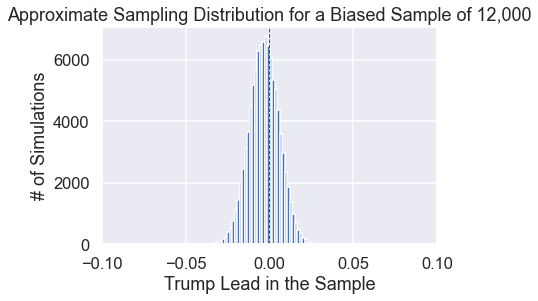

In [17]:
plt.hist(simulations_bias_big, bins=50)
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
plt.xlim([-0.1, 0.1])
plt.title('Approximate Sampling Distribution for a Biased Sample of 12,000') 
plt.ylabel('# of Simulations')
plt.xlabel('Trump Lead in the Sample')

After the fact, with multiple polls for the same election, we can detect bias. In a post-election analysis of over 4,000 polls for 600 state-level, gubernatorial, senatorial, and presidential elections, {cite}`shirani2018` found that on average election polls exhibit a bias of about 1.5 percentage points. 

When the margin of victory is relatively small as it was in 2016, a larger sample size reduces the sampling error, but unfortunately, if there is bias, then the predictions are close to the biased estimate. If the bias pushes the prediction from one candidate (Trump) to another (Clinton), then we have a "surprise" upset. Pollsters develop voter selection schemes that attempt to reduce bias, like the separation of voters preference by education level, but, as in this case, it can be difficult, even impossible, to account for new, unexpected sources of bias. Polls are still useful, but we need to acknowledge the issues with bias and do a better job at reducing bias. 

In this example we used the urn model to study a SRS in polling. Another common use of the urn is in randomized controlled experiments.